# A Simple Illustration of a 2-Dimensional Groundwater Model
## By: Lejo Flores

This is an example of a 2-dimensional groundwater model in which the domain is square, heterogeneous, and isotropic (i.e., there is one value of hydraulic conductivity $K_{sat}$ that is valid everywhere in the domain and in all directions). The purpose of this Jupyter notebook is to illustrate how solution of the groundwater flow equations (conservation of mass and Darcy's Law) is largely an extension of the previously reviewed 1D examples into a second dimension. 

Conceptually this model is really quite simple - in addition to gradients in pressure head in the $x$ direction we also now need to compute pressure head gradients in the $y$ direction. We will reduce this problem to a suite of discrete linear relationships and use linear algebra, matrix-vector multiplication to solve the system of equations. This requires us to represent, or "flatten," our 2D domain into a column vector. However, where this introduces complications in the numerics is in the "bookkeeping" of keeping track of where in our column vector the cells that were north and south of a central pixel now are after we "flatten" our domain. I will actually illustrate how this works out using a "100s chart" from my daughters 1st grade classroom, because that's the simplist way to figure out how this works in a general way. 

## A Review of the Maths

\begin{equation}
\frac{\partial^2h}{\partial x^2}+\frac{\partial^2h}{\partial y^2}=\frac{S}{T}\frac{\partial h}{\partial t} - \frac{R(x,y,t)}{T}
\end{equation}

<img src="img/5pt_Stencil.png" style="width: 300px;"/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

hi = 80.0
hf = 10.0
K = 16.0

ti = 0.0
tf = 500.0
dt = 0.1

OutputInterval = 50.0

Nt = (tf - ti)/dt + 1

Noutput = (tf - ti)/OutputInterval + 1

xMax = yMax = 500.0
xMin = yMin = 0.0
Nx = Ny = 50

x = np.linspace(xMin,xMax,Nx)
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

## Plot the X and Y grid meshes

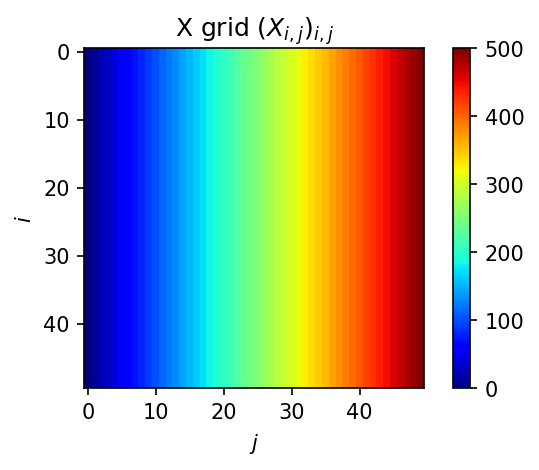

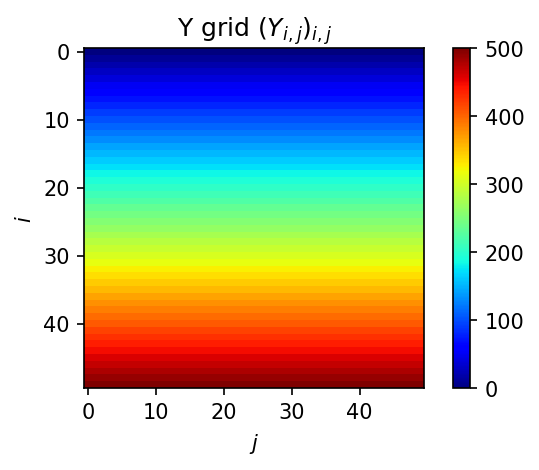

In [2]:
# Plot X grid
plt.figure(1,figsize=(5,3), dpi=150)
plt.title("X grid $(X_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(X,cmap="jet")
plt.colorbar()
plt.show()

# Plot Y grid
plt.figure(2,figsize=(5,3), dpi=150)
plt.title("Y grid $(Y_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(Y,cmap="jet")
plt.colorbar()
plt.show()


## Compute the stability variable 

In [3]:
alpha = K*dt/dx**2
print("alpha = ",alpha)
print("dt = ",dt)
print("dx = ",dx)
if alpha >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.0153664
dt =  0.1
dx =  10.2040816327


## Set up the solver matrix 


<img src="img/100sChart.png" style="width: 600px;"/>

<img src="img/100sChartStencilEx.png" style="width: 600px;"/>


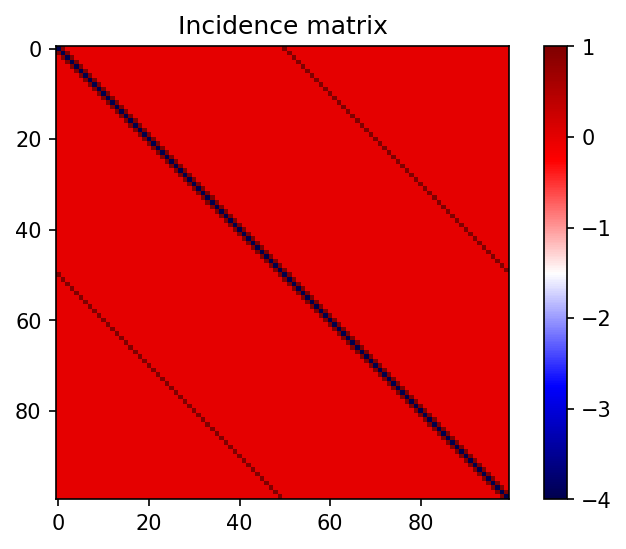

In [4]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))

plt.figure(3,figsize=(6,4), dpi=150)
plt.title("Incidence matrix")
plt.imshow(Delta2[0:(2*int(Ny)),0:(2*int(Nx))],cmap="seismic")
plt.colorbar()
plt.show()

## Setting up the boundary conditions

In [5]:
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

hNEt = np.linspace(hi,hf,num=Nt,endpoint=True)

# Now compute the boundary conditions on the North and East side of the domain as the temporal evolution of a !D
# profile in response to a lowering of head on 1-side of the domain

Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

H_1D[:,0] = np.matrix(h0_1D)

for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1]
        
    hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D
    hnext_1D[0] = hi
    hnext_1D[-1] = hNEt[i]

    H_1D[:,i] = hnext_1D[:,0]



## Running the model

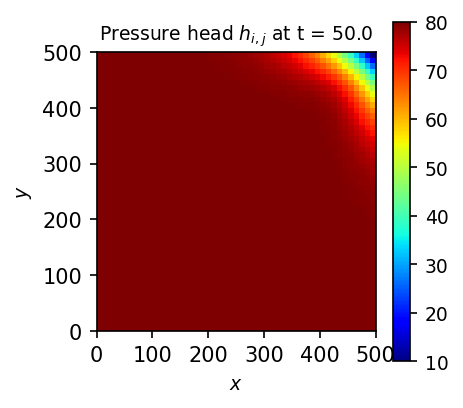

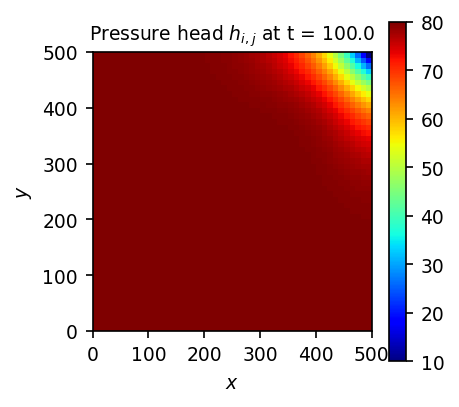

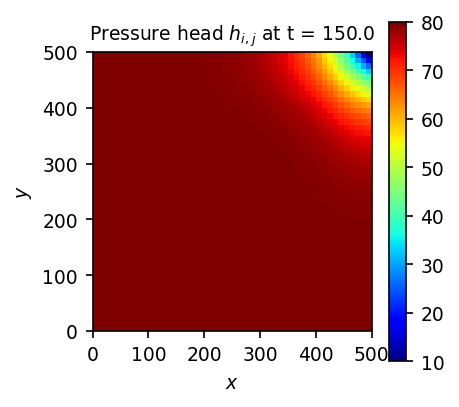

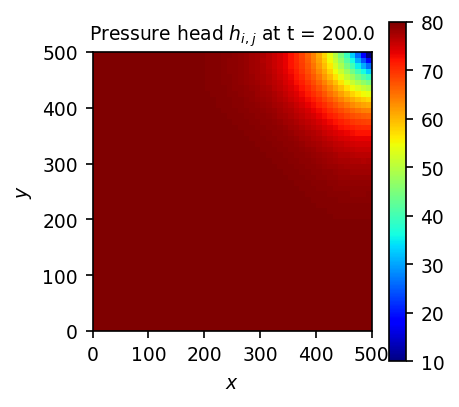

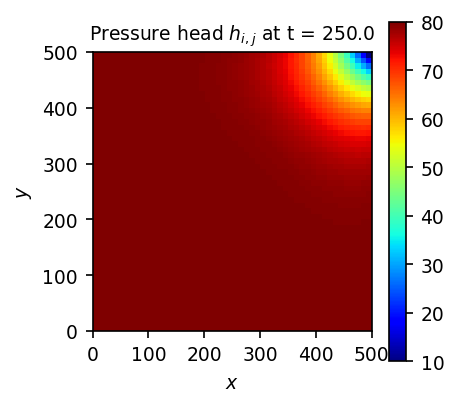

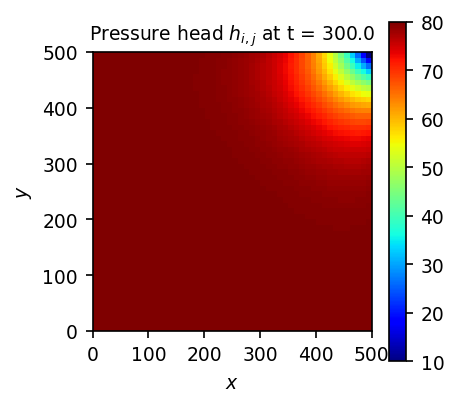

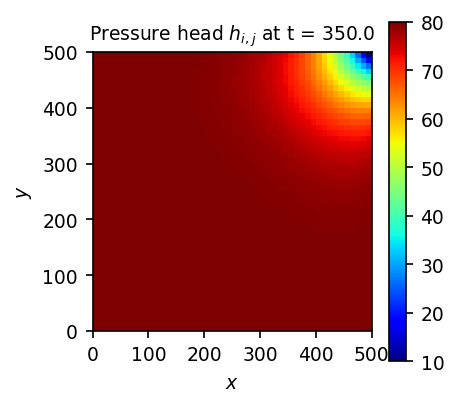

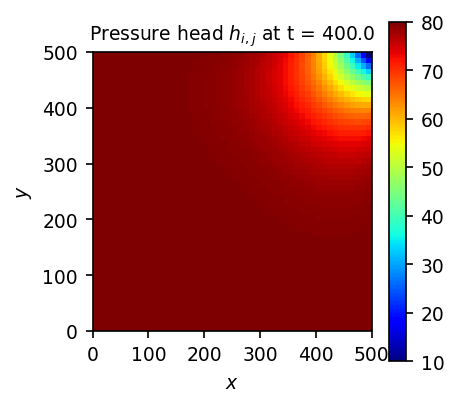

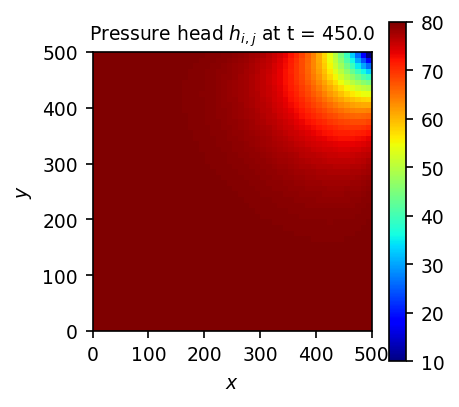

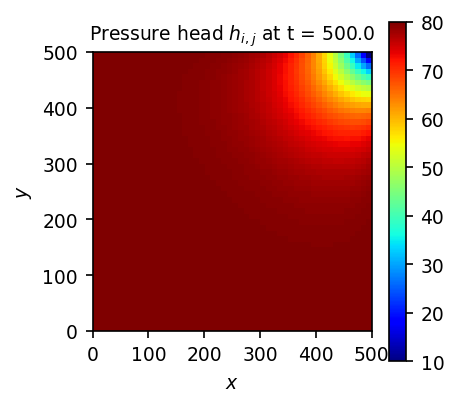

In [6]:
import matplotlib as mpl

h0 = hi*np.ones(shape=(int(N),1))
hnext = np.matrix(h0)

figcounter = 1

for i in range(1,int(Nt)):
    hinit = hnext
    
    hnext = hinit + alpha*Delta2*hinit
    hnext[NBound.astype(int)] = H_1D[:,-1]
    hnext[EBound.astype(int)] = np.flipud(H_1D[:,-1])
    hnext[SBound.astype(int)] = hi
    hnext[WBound.astype(int)] = hi
    
    if((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))
        fig = plt.figure(figcounter, figsize=(3,3), dpi=150)
        plt.title("Pressure head $h_{i,j}$ at t = %s"%(i*dt), fontsize=9)
        plt.xlabel('$x$', fontsize=9)
        plt.ylabel('$y$', fontsize=9)
        plt.xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        plt.yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 9
        mpl.rcParams['ytick.labelsize'] = 9        
        plt.imshow(H,cmap="jet",extent=[xMin,xMax,yMin,xMax],vmin=hf,vmax=hi)
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=9) 
        plt.show()
        figcounter = figcounter + 1

        